# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données

In [2]:
interactions_test = pd.read_csv('data/interactions_test.csv')
interactions_train = pd.read_csv('data/interactions_train.csv')
RAW_interactions = pd.read_csv('data/RAW_interactions.csv')
RAW_recipes = pd.read_csv('data/RAW_recipes.csv')

# Exploration des données

### Affichage du contenu des fichiers

In [3]:
print(f"Interactions train {interactions_train.shape}  | keys : {interactions_train.keys().to_list()}")
print(interactions_train.head(3))

Interactions train (698901, 6)  | keys : ['user_id', 'recipe_id', 'date', 'rating', 'u', 'i']
   user_id  recipe_id        date  rating      u       i
0     2046       4684  2000-02-25     5.0  22095   44367
1     2046        517  2000-02-25     5.0  22095   87844
2     1773       7435  2000-03-13     5.0  24732  138181


In [4]:
print(f"Interactions test {interactions_test.shape}   | keys : {interactions_test.keys().to_list()}")
print(interactions_test.head(3))

Interactions test (12455, 6)   | keys : ['user_id', 'recipe_id', 'date', 'rating', 'u', 'i']
   user_id  recipe_id        date  rating   u       i
0     8937      44551  2005-12-23     4.0   2  173538
1    56680     126118  2006-10-07     4.0  16  177847
2   349752     219596  2008-04-12     0.0  26   89896


In [5]:
print(f"RAW interactions {RAW_interactions.shape} | keys : {RAW_interactions.keys().to_list()}")
print(RAW_interactions.head(3))

RAW interactions (1132367, 5) | keys : ['user_id', 'recipe_id', 'date', 'rating', 'review']
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  


In [6]:
print(f"RAW recipes {RAW_recipes.shape} | keys : {RAW_recipes.keys().to_list()}")
print(RAW_recipes.head(3))

RAW recipes (231637, 12) | keys : ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   

                                    nutrition  n_steps  \
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9   
2  [269.8, 22.0, 32.0, 4

### Exploration des notes

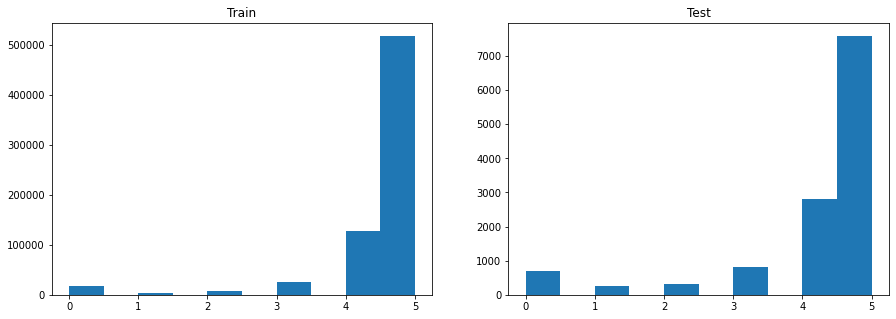

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(interactions_train.rating)
plt.title("Train")
plt.subplot(1,2,2)
plt.hist(interactions_test.rating)
plt.title("Test")
plt.show()

### Isolation des notes nulles

In [8]:
RAW_interactions.loc[RAW_interactions.rating ==0]["review"]

6          Just an observation, so I will not rate.  I fo...
12         Made my own buttermilk w/ vinegar and milk.  U...
23         This is a very good recipe.  We also want to c...
39                              i made it and it was amazing
56         I used half cream and half 1% milk, added anot...
                                 ...                        
1132318    Delicious ! I tweeked the recipe a bit>>substi...
1132323    Just added this mix to a homemade beef &amp; s...
1132325    Would this make a good hamburger patty seasoning?
1132361    I am not going to rate this because I did have...
1132362    Another approach is to start making sauce with...
Name: review, Length: 60847, dtype: object

Les notes nulles correspondent dans la plupart des cas à des commentaires positifs, on les supprime donc.

### Elimination des notes nulles et création du label "positive"

In [9]:
RAW_interactions_clean = RAW_interactions.drop(RAW_interactions[RAW_interactions.rating == 0].index).fillna('')

In [10]:
RAW_interactions_clean["positive"] = RAW_interactions_clean.rating.apply(lambda x: x > 3)

In [11]:
RAW_interactions_clean.head(5)

,user_id,recipe_id,date,rating,review,positive
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,True
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",True
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,True
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,True
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",True


### Train test split

In [12]:
from sklearn.model_selection import train_test_split

max_elements = 10000
test_size = 0.2

train_clean, test_clean = train_test_split(RAW_interactions_clean.iloc[:max_elements], test_size=test_size, random_state=0, shuffle=False)
data_clean = RAW_interactions_clean.iloc[:max_elements]

# TFIDF basique

### Calcul de la matrice TFIDF et de la distance entre les avis

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [14]:
tfidf = TfidfVectorizer(stop_words='english', max_features = 100)
tfidf_matrix = tfidf.fit_transform(train_clean['review'])

In [15]:
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

### Calcul des avis proches et affichage de leur note

In [16]:
def get_closest(idx, sim_matrix, num_neighbors=5):
  print(f'original: ({train_clean.iloc[idx]["rating"]}/5) {train_clean.iloc[idx]["review"]}\n')
  closest = sim_matrix[idx].argsort()[1:num_neighbors+1]
  for i in range(0,num_neighbors):
    print(f'{i+1}/ ({train_clean.iloc[closest[i]]["rating"]}/5) {train_clean.iloc[closest[i]]["review"]}\n')

In [17]:
get_closest(1, cosine_sim, num_neighbors=3)

original: (5/5) So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!

1/ (5/5) This was a great tasting and delicious healthy lunch! Love that it's so simple, yet tastes so good. Love the dressing too; just the right amount of freshness and tartness from the limes!

2/ (5/5) I kind of surprised myself with this one, I had to pick up a few of the items at the store, but so what! It was worth it! This is my second time back to get the recipe, which is why Im rating it a 5. Little experience needed - Overall fairly simple! Love It! Love It!

3/ (5/5) Delicious! Great flavors! Love capers! Made as directed. Thanks, IngridH! I will make this again and again. Made the first time for PRMR tag game.



# TFIDF avec Stemming

### Calcul de la matrice TFIDF

In [18]:
from nltk import word_tokenize          
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
# Download stopwords list

stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','!', '#', '$', '%', '&', "'", "'m", '(', ')', '*', '-', '--', '..',
       '...', '....', '.....', '......', '...........', '.i', '.it',
       '.zaar', '/', '039', '08', '1', '1-2', '1.5', '1/2', '1/2tsp',
       '1/3', '1/4', '1/8/09', '10', '10.', '10/18/10', '103024', '10oz',
       '1108690', '114718', '12', '12/22/08', '13', '14', '146530', '15',
       '154943.', '17th', '18', '1970', '1st', '1t', '2', '2-4', '2.',
       '2/3', '20', '20-30', '200', '2007.', '2008', '2009', '2010',
       '2011', '2012', '2013', '2017', '2018', '211485', '221973',
       '2bleu', '2tbs', '3', '3-4', '3/4', '30', '32', '326538', '35',
       '350f', '392938', '4', '4-5', '4.5', '40', '425', '425f', '462620',
       '5', '5-6', '55856', '5th', '6', '680grms', '7', '7.5', '75',
       '79-year-old', '8', '81194', '9','9-inch', '9.', '95', '9x13', '9x13x2', '<', '=', '=-', '>', '?',
       '@', '[', ']', 'zwt0',
       'zwt5', 'zwt6', 'zwt8', '~', '’', '“', '”']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

tokenizer = StemTokenizer()
token_stop = tokenizer(' '.join(stop_words))

[nltk_data] Downloading package punkt to
[nltk_data]     /home/vuong.nguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vuong.nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
import random
index_to_drop = random.sample(train_clean.index[train_clean.positive == True].to_list(), 5000)
train_clean = train_clean.drop(index_to_drop)
data_clean = data_clean.drop(index_to_drop)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-idf model
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, ngram_range=(1,1))

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data_clean['review'])

In [21]:
import pickle

with open('tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Prédiction de la note

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

2023-06-16 14:30:27.681479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 14:30:27.780522: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-16 14:30:28.932414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/11.2-v8.1.0/cuda/lib64:/usr/local/cuda-11.2/lib64:/usr/local/TensorRT/TensorRT-8.5.1.7/lib
2023-06-16 14:30:28.932466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [23]:
X_train = tfidf_matrix.toarray()[:3000,:]
y_train = to_categorical(train_clean["positive"].values.astype(int), 2)
review_train = train_clean["review"].values
X_test = tfidf_matrix.toarray()[3000:,:]
y_test = to_categorical(test_clean["positive"].values.astype(int), 2)
review_test = test_clean["review"].values

### Définition et entraînement du modèle

In [24]:
model = Sequential()
model.add(Dense(300, input_shape=(tfidf_matrix.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

2023-06-16 14:30:31.072004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 14:30:31.075155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 14:30:31.075250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 14:30:31.075615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [25]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

/home/vuong.nguyen/.conda/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
model.fit(X_train, y_train, epochs=15, batch_size=100, verbose=1)

Epoch 1/15
30/30 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.7790
Epoch 2/15
30/30 [==============================] - 0s 2ms/step - loss: 0.5422 - accuracy: 0.8287
Epoch 3/15
30/30 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.8287
Epoch 4/15
 1/30 [>.............................] - ETA: 0s - loss: 0.4512 - accuracy: 0.8100

2023-06-16 14:30:32.368218: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30/30 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8287
Epoch 5/15
30/30 [==============================] - 0s 2ms/step - loss: 0.3756 - accuracy: 0.8287
Epoch 6/15
30/30 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8287
Epoch 7/15
30/30 [==============================] - 0s 2ms/step - loss: 0.3161 - accuracy: 0.8287
Epoch 8/15
30/30 [==============================] - 0s 2ms/step - loss: 0.2835 - accuracy: 0.8287
Epoch 9/15
30/30 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.8287
Epoch 10/15
30/30 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.8323
Epoch 11/15
30/30 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.8677
Epoch 12/15
30/30 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9260
Epoch 13/15
30/30 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9633
Epoch 14/15
30/30 [========

In [27]:
print("Proportion d'avis positifs dans le dataset : ", sum(y_train[:,0] == 0)/len(y_train[:,0]))
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Proportion d'avis positifs dans le dataset :  0.8286666666666667


63/63 [==============================] - 0s 1ms/step - loss: 0.1634 - accuracy: 0.9455
Accuracy: 94.55


In [28]:
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://f525bdaf-89e6-4cd0-841f-389fe5e3eb2e/assets


# XAI - Lime

In [29]:
from lime.lime_tabular import LimeTabularExplainer
class_names=['Negative', 'Positive']
explainer = LimeTabularExplainer(X_test, feature_names=tfidf.get_feature_names(), class_names=class_names)

/home/vuong.nguyen/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
index = 1
exp = explainer.explain_instance(X_test[index], model.predict, num_features=20)
exp.show_in_notebook(show_table=True, show_all=True)
prediction = model.predict(np.array([X_test[index]]))
class_predicted = class_names[prediction.argmax(1)[0]]
class_proba = prediction.max(1)[0]
true_class = class_names[np.argmax(y_test[index])]
print(f'Class predicted: {class_predicted} (p={class_proba})')
print(f'True class: {true_class}')

157/157 [==============================] - 0s 834us/step


1/1 [==============================] - 0s 12ms/step
Class predicted: Positive (p=1.0)
True class: Positive


## Interprétation avec LimeTextExplainer

In [31]:
def make_pred_from_text(text):
    if type(text) == str:
        text = np.array([text])
    tfidf_data = tfidf.transform(text).toarray()
    return model.predict(tfidf_data)

In [32]:
print("Avis négatifs bien prédits : ", np.sort(list(set(list(np.where(model.predict(X_test)[:,0] > 0.5)[0])).intersection(list(np.where(y_test[:,0] == 1)[0])))))

63/63 [==============================] - 0s 820us/step
Avis négatifs bien prédits :  [  42  245  283  284  339  344  346  349  362  417  432  506  532  586
  676  689  690  693  705  707  709  760  801  844  890  893  932  950
  957  987  995 1025 1026 1027 1049 1052 1074 1088 1298 1394 1613 1727
 1777 1803 1804 1921 1980]


In [33]:
from lime.lime_text import LimeTextExplainer

class_names = ['Negative', 'Positive']

explainer = LimeTextExplainer(class_names=class_names)

index = 257
exp = explainer.explain_instance(review_test[index], make_pred_from_text, num_features=20)

prediction = make_pred_from_text(review_test[index])
class_predicted = class_names[prediction.argmax(1)[0]]
class_proba = prediction.max(1)[0]
true_class = class_names[int(y_test[index,1])]
print(f'Class predicted: {class_predicted} (p={class_proba})')
print(f'True class: {true_class}')

1/1 [==============================] - 0s 15ms/step
Class predicted: Positive (p=0.5491518378257751)
True class: Negative


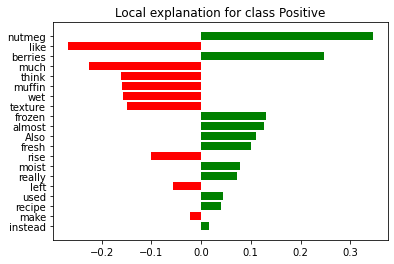

In [34]:
fig = exp.as_pyplot_figure()

In [35]:
exp.show_in_notebook(text=True)

### SHAP

In [36]:
import shap

In [ ]:
feature_names = tfidf.get_feature_names_out()
explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)
print(shap_values.values.shape) # (5000, 16438, 2)

In [ ]:
shap.initjs()

ind = 6
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])